In [ ]:
#!ls -lh /helium/analysis/daehyun
!cat /helium/analysis/daehyun/F1p.ini

In [92]:
import ROOT

ModuleNotFoundError: No module named 'ROOT'

In [86]:
from glob import iglob
from functools import reduce
from typing import Iterable

from numpy import ndarray, linspace, histogram2d, array
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import udf, col, explode, pandas_udf, PandasUDFType
import matplotlib.pyplot as plt
from sp8tools import SpkHits

In [87]:
builder = (SparkSession
           .builder
           .appName("PySpark Example")
#            .master("spark://carbon.uedalab.local:7077")
           .config("spark.jars.packages", "org.diana-hep:spark-root_2.11:0.1.15")
#            .config("spark.cores.max", 1)
           .config("spark.executor.cores", 5)
           .config("spark.executor.memory", "16g")
           )
spark = builder.getOrCreate()

In [88]:
globbed = iglob("/helium/analysis/daehyun/SortEvent_aq002_t100_b.root")
loaded = (spark.read.format("org.dianahep.sparkroot").load(fn) for fn in globbed)
df = reduce(DataFrame.union, loaded)
df.printSchema()

root
 |-- SortedEvent: struct (nullable = true)
 |    |-- fEventID: long (nullable = true)
 |    |-- fDetektors: array (nullable = true)
 |    |    |-- element: struct (containsNull = true)
 |    |    |    |-- fDetektors_fHits: array (nullable = true)
 |    |    |    |    |-- element: struct (containsNull = true)
 |    |    |    |    |    |-- fPDNbr: integer (nullable = true)
 |    |    |    |    |    |-- fHitNbr: integer (nullable = true)
 |    |    |    |    |    |-- fU1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fU2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fV1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fV2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fW1Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fW2Nbr: integer (nullable = true)
 |    |    |    |    |    |-- fMcpNbr: integer (nullable = true)
 |    |    |    |    |    |-- fX_mm: double (nullable = true)
 |    |    |    |    |    |-- fY_mm: double (

In [89]:
@udf(SpkHits)
def combine_hits(xarr, yarr, tarr, flagarr):
    return [{'x': x,
             'y': y,
             't': t,
             'flag': f
            } for x, y, t, f in zip(xarr, yarr, tarr, flagarr)]


chits = col('SortedEvent.fDetektors')[0]['fDetektors_fHits']
restructed = (df
              .withColumn('hits', combine_hits(chits.getField('fX_mm'),
                                               chits.getField('fY_mm'),
                                               chits.getField('fTime'),
                                               chits.getField('fRekmeth')))
              .select(col('SortedEvent.fEventID').alias("tag"), 'hits'))
restructed.printSchema()

root
 |-- tag: long (nullable = true)
 |-- hits: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- t: double (nullable = false)
 |    |    |-- x: double (nullable = false)
 |    |    |-- y: double (nullable = false)
 |    |    |-- flag: integer (nullable = true)
 |    |    |-- as: map (nullable = true)
 |    |    |    |-- key: string
 |    |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |    |-- px: double (nullable = false)
 |    |    |    |    |-- py: double (nullable = false)
 |    |    |    |    |-- pz: double (nullable = false)
 |    |    |    |    |-- ke: double (nullable = false)



In [90]:
flatten = (
    restructed
    .select('tag', explode('hits').alias('hit'))
    .select('tag', 'hit.*')
    .repartition(8)
    .cache()
)
flatten.show()

+---------+------------------+-------------------+-------------------+----+----+
|      tag|                 t|                  x|                  y|flag|  as|
+---------+------------------+-------------------+-------------------+----+----+
|146305919|2111.0528982539954| 1.3921147030365846|  5.516630771102777|   0|null|
|146325401| 752.7173759083157|-11.395110511169536| -12.01512013134359|   0|null|
|146330797|1178.7450021912632|-10.206554040532007| 2.0450087139685387|   8|null|
|146035670|1044.4891028322986|  21.61718282800947| -4.945422388097816|  19|null|
|146323971| 2962.779431164727|  2.116629744648306| 1.9149259217017092|   0|null|
|146227755| 3150.576331272013| -9.544215371965537| -5.463788972780517|  17|null|
|146149954|1037.7526626936976|-12.942522443888583|  8.318908692374139|   0|null|
|146316606|  828.389703374951| 13.108839073962294| 30.822471896154557|   0|null|
|146309859|2989.0669464273537| 0.8568482033540069|  4.812908287711406|   0|null|
|146298020| 808.999051674515

In [59]:
def _hist(it: Iterable[list]) -> Iterable[ndarray]:
    arr = array(list(it))
    h, *_ = histogram2d(
        arr[:, 0],
        arr[:, 1],
        bins=[1000, 1000],
        range=[[0, 8000], [-50, 50]]
    )
    yield h
    return 


xedges = linspace(0, 8000, 1000+1)
yedges = linspace(-50, 50, 1000+1)
hist = (
    flatten
    .select('t', 'x')
    .rdd
    .map(list)
    .mapPartitions(_hist)
    .sum()
)

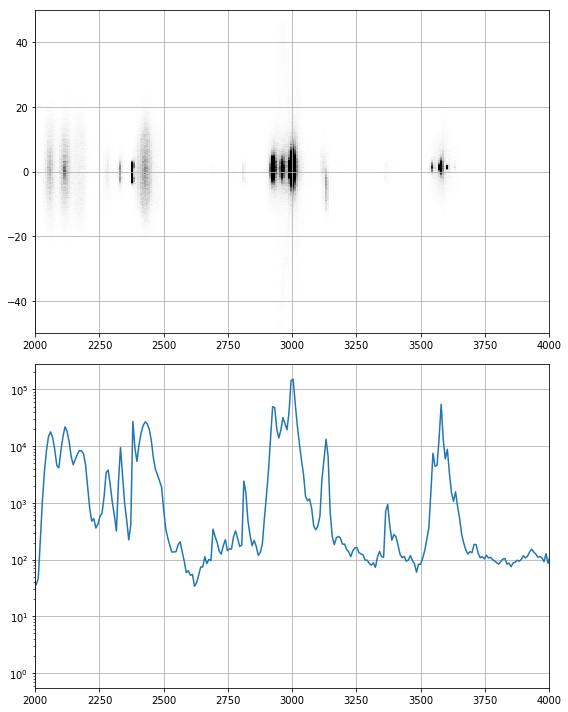

In [60]:
plt.figure(figsize=(8, 10))
plt.subplot(211)
plt.pcolormesh(xedges, yedges, hist.T, cmap="Greys")
plt.xlim(2000, 4000)
plt.clim(0, 250)
plt.grid(True)

plt.subplot(212)
plt.plot((xedges[1:]+xedges[:-1])/2, hist.sum(1))
plt.xlim(2000, 4000)
plt.grid(True)
plt.yscale("log")

plt.tight_layout()
plt.show()

In [9]:
@udf('double')
def fPzRT(x, y):
    """
    parameter[i] = Spectrometer.Region{i+1}.EField_VPercm
    fitting function(x, y) = [0]+[1]*y+[2]*y*y+[3]*y*y*y+[4]*y*y*y*y+[5]*x*x+[6]*x*x*x*x
    """
    par0 = 11020.8
    par1 = -15.0334
    par2 = 0.000517299
    par3 = 4.6306e-006
    par4 = -1.20176e-009
    par5 = -0.0178001
    par6 = 8.42954e-007
    return par0 + par1*y + par2*y**2 + par3*y**3 + par4*y**4 + par5*x**2 + par6*x**4


@udf('double')
def fPrRT(x, y):
    """
    parameter[i] = Spectrometer.Region{i+1}.Length_mm
    fitting function(x, y) = [0]*x+[1]*x*y+[2]*x*x*x*y+[3]*x*x*x*x*x*y+[4]*y*y*y+[5]*y*y*y*y*y
    """
    par0 = 8.23477
    par1 = -0.000593609
    par2 = 3.98001e-008
    par3 = 2.07869e-012
    par4 = 6.26017e-010
    par5 = -1.96245e-016
    return par0*x + par1*x*y + par2*x**3*y + par3*x**5*y + par4*y**3 + par5*y**5

In [56]:
analyzed = (
    flatten
    .filter('2395<t AND t<2535')
    .withColumn('t', col('t')-635)
    .withColumn('px', fPrRT('x', 't'))
    .withColumn('py', fPrRT('y', 't'))
    .withColumn('pz', fPzRT((col('x')**2+col('y')**2)**0.5, 't'))
)

+---------+------------------+-------------------+--------------------+----+----+-------------------+-------------------+-------------------+
|      tag|                 t|                  x|                   y|flag|  as|                 px|                 py|                 pz|
+---------+------------------+-------------------+--------------------+----+----+-------------------+-------------------+-------------------+
|146028215|1802.0956618244268| 7.1060221934117935|  1.9299281333629343|   0|null|  50.87454309309506| 13.762386680992357|  33.81015473440145|
|146130375|1795.9376916076303| 11.642157416372456|  11.923506350550515|   0|null|  83.53229252343493|  85.55767221354928|  6.498248001383743|
|146161922|1784.4187786005023| -3.721395885615126|   8.863574597178452|   5|null|-26.700127701785902|  63.65693729124521|-33.571470516842545|
|146089229|1786.5272264285313|  18.85313605823315| -1.9448431757219444|  14|null| 135.74093405691772|-13.955261181183147| -30.33704935970268|
|14624

In [61]:
df = analyzed.toPandas()

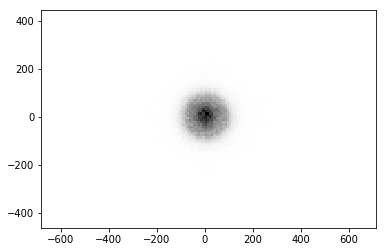

In [69]:
plt.figure()
plt.hist2d(df['px'], df['py'], bins=(100, 100), cmap='Greys')
plt.axis('equal')
plt.show()

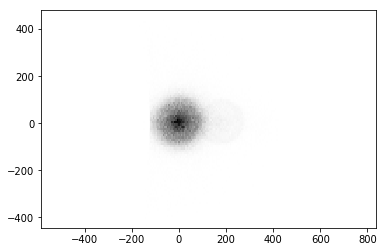

In [70]:
plt.figure()
plt.hist2d(df['pz'], df['px'], bins=(100, 100), cmap='Greys')
plt.axis('equal')
plt.show()

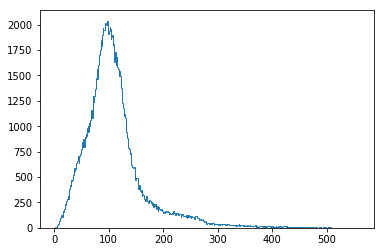

In [79]:
plt.figure()
plt.hist((df['px']**2+df['py']**2+df['pz']**2)**0.5, bins=500, histtype='step')
plt.show()

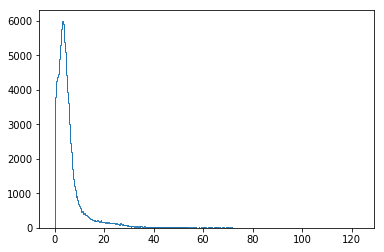

In [84]:
plt.figure()
plt.hist((df['px']**2+df['py']**2+df['pz']**2)/2/1822.888486192/18.9984032*27.2114, bins=500, histtype='step')
plt.show()